In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Dataset

In [3]:
data = {}
import json
with open('nvdcve-1.1-2023.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

#print(data)

In [13]:
def severity2score(str):
    if str == 'NONE'or str == 'LOCAL' or str == 'UNCHANGED' or str == '':
        return 0
    elif str == 'LOW' or str == 'REQUIRED' or str == 'CHANGED' or str == 'NETWORK':
        return 1
    elif str == 'MEDIUM' or str == 'ADJACENT_NETWORK':
        return 2
    elif str == 'HIGH' or str == 'PHYSICAL' :
        return 3
    elif str == 'CRITICAL':
        return 4
    else:
        print(str)

cve_items = data.get("CVE_Items", [])
entries = []

for item in cve_items:
    entry = {
        #"ID": item['cve']['CVE_data_meta']['ID'],
        #"Problem Type": item['cve']['problemtype']['problemtype_data'][0]['description'],
        #"CVSS Version": item['impact']['baseMetricV3']['cvssV3']['version'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "",
        #"CVSS Vector": item['impact']['baseMetricV3']['cvssV3']['vectorString'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "",
        "Base Score": float(item['impact']['baseMetricV3']['cvssV3']['baseScore'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "0"),
        "Severity":  item['impact']['baseMetricV3']['cvssV3']['baseSeverity'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "NEI",
        #"Description": item['cve']['description']['description_data'][0]['value'],
        #"Config": item['configurations'],
        #"Reference": item['cve']['references'],
        "Attack Complexity": severity2score(item['impact']['baseMetricV3']['cvssV3']['attackComplexity'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Privileges Required": severity2score(item['impact']['baseMetricV3']['cvssV3']['privilegesRequired'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "User Interaction": severity2score(item['impact']['baseMetricV3']['cvssV3']['userInteraction'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Confidentiality Impact": severity2score(item['impact']['baseMetricV3']['cvssV3']['confidentialityImpact'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Integrity Impact": severity2score(item['impact']['baseMetricV3']['cvssV3']['integrityImpact'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Availability Impact": severity2score(item['impact']['baseMetricV3']['cvssV3']['availabilityImpact'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Attack Vector": severity2score(item['impact']['baseMetricV3']['cvssV3']['attackVector'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Scope": severity2score(item['impact']['baseMetricV3']['cvssV3']['scope'] if 'impact' in item and 'baseMetricV3' in item['impact'] else ""),
        "Exploitability Score": float(item['impact']['baseMetricV3']['exploitabilityScore'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "0"),
        "Impact Score": float(item['impact']['baseMetricV3']['impactScore'] if 'impact' in item and 'baseMetricV3' in item['impact'] else "0"),
        
    }
    entries.append(entry)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(entries)

# Calculate the shape of the DataFrame
num_entries, num_features = df.shape
# Save the DataFrame as a CSV file
df.to_csv("cve_data.csv", index=False)

print("CSV file 'cve_data.csv' saved successfully.")
df.shape

CSV file 'cve_data.csv' saved successfully.


(14881, 12)

In [14]:
df.head()


,Base Score,Severity,Attack Complexity,Privileges Required,User Interaction,Confidentiality Impact,Integrity Impact,Availability Impact,Attack Vector,Scope,Exploitability Score,Impact Score
0,6.7,MEDIUM,1,3,0,3,3,3,0,0,0.8,5.9
1,7.8,HIGH,1,1,0,3,3,3,0,0,1.8,5.9
2,6.5,MEDIUM,1,1,0,3,0,0,1,0,2.8,3.6
3,6.5,MEDIUM,1,3,0,0,3,3,1,0,1.2,5.2
4,4.9,MEDIUM,1,3,0,3,0,0,1,0,1.2,3.6


In [64]:
print(df["Severity"].value_counts())
encoder = LabelBinarizer()
encoder.fit(df["Severity"])
X = pd.concat([df["Base Score"],df["Attack Complexity"],df["Privileges Required"],df["User Interaction"]
               ,df["Confidentiality Impact"],df["Integrity Impact"],df["Availability Impact"],df["Attack Vector"]
               ,df["Scope"],df["Exploitability Score"],df["Impact Score"]], axis=1)
y = encoder.transform(df["Severity"])
num_labels = len(encoder.classes_)
print(X.shape, y.shape)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)
X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

Severity
MEDIUM      6645
HIGH        5340
CRITICAL    2237
NEI          429
LOW          230
Name: count, dtype: int64
(14881, 11) (14881, 5)


In [65]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train shape:", X_test.shape)
print("y_train shape:", y_test.shape)

print("X_test:", X_test)
print("y_test:", y_test)

X_train shape: (11904, 11)
y_train shape: (11904, 5)
X_train shape: (2977, 11)
y_train shape: (2977, 5)
X_test: [[4.3 1.  1.  ... 0.  2.8 1.4]
 [8.8 1.  0.  ... 0.  2.8 5.9]
 [9.8 1.  0.  ... 0.  3.9 5.9]
 ...
 [6.1 1.  0.  ... 1.  2.8 2.7]
 [0.  0.  0.  ... 0.  0.  0. ]
 [7.  3.  1.  ... 0.  1.  5.9]]
y_test: [[0 0 0 1 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 1 0 0 0]]


In [66]:


model = keras.Sequential([
    keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(num_labels, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [67]:
#early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=10, batch_size=8, validation_split= .2, verbose=2)#, callbacks=[early_stopping])

Epoch 1/10
1191/1191 - 3s - loss: 0.1778 - accuracy: 0.9373 - val_loss: 0.0308 - val_accuracy: 0.9912 - 3s/epoch - 2ms/step
Epoch 2/10
1191/1191 - 2s - loss: 0.0484 - accuracy: 0.9858 - val_loss: 0.0253 - val_accuracy: 0.9933 - 2s/epoch - 2ms/step
Epoch 3/10
1191/1191 - 2s - loss: 0.0436 - accuracy: 0.9873 - val_loss: 0.3750 - val_accuracy: 0.8967 - 2s/epoch - 2ms/step
Epoch 4/10
1191/1191 - 2s - loss: 0.0370 - accuracy: 0.9878 - val_loss: 0.0313 - val_accuracy: 0.9895 - 2s/epoch - 2ms/step
Epoch 5/10
1191/1191 - 2s - loss: 0.0215 - accuracy: 0.9940 - val_loss: 0.0170 - val_accuracy: 0.9950 - 2s/epoch - 2ms/step
Epoch 6/10
1191/1191 - 2s - loss: 0.0292 - accuracy: 0.9916 - val_loss: 0.0178 - val_accuracy: 0.9945 - 2s/epoch - 2ms/step
Epoch 7/10
1191/1191 - 2s - loss: 0.0231 - accuracy: 0.9931 - val_loss: 0.0350 - val_accuracy: 0.9929 - 2s/epoch - 2ms/step
Epoch 8/10
1191/1191 - 2s - loss: 0.0276 - accuracy: 0.9923 - val_loss: 0.0160 - val_accuracy: 0.9950 - 2s/epoch - 2ms/step
Epoch 9/

In [68]:
X_test.shape

(2977, 11)

94/94 [==============================] - 0s 962us/step
F1 Score: 0.998319177427735
373/373 - 0s - loss: 0.0060 - accuracy: 0.9983 - 299ms/epoch - 803us/step
Test accuracy: 0.998320460319519


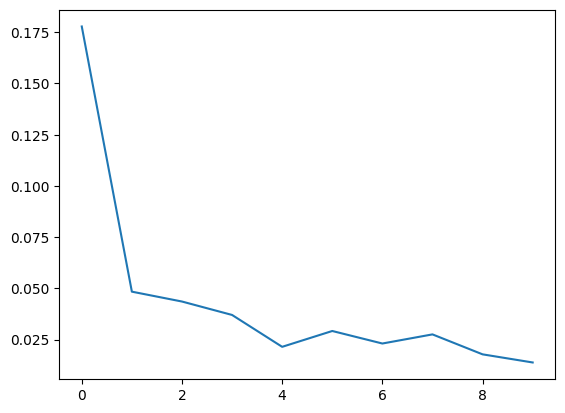

In [71]:
from sklearn.metrics import f1_score
# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_test_ = encoder.inverse_transform(y_test)
y_pred_ = encoder.inverse_transform(y_pred)
f1 = f1_score(y_test_, y_pred_ , average='weighted')
print("Weighted F1 Score:", f1)


score, acc = model.evaluate(X_test, y_test, batch_size=8, verbose=2)
print('Test accuracy:', acc)
# Optionally, you can visualize the training history to see the loss curve
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')

1/1 [==============================] - 0s 17ms/step
Actual label: [0 0 0 1 0]
Predicted label:  MEDIUM
1/1 [==============================] - 0s 17ms/step
Actual label: [0 1 0 0 0]
Predicted label:  HIGH
1/1 [==============================] - 0s 17ms/step
Actual label: [1 0 0 0 0]
Predicted label:  CRITICAL
1/1 [==============================] - 0s 18ms/step
Actual label: [0 1 0 0 0]
Predicted label:  HIGH
1/1 [==============================] - 0s 18ms/step
Actual label: [0 1 0 0 0]
Predicted label:  HIGH
1/1 [==============================] - 0s 17ms/step
Actual label: [0 1 0 0 0]
Predicted label:  HIGH
1/1 [==============================] - 0s 18ms/step
Actual label: [0 0 0 1 0]
Predicted label:  MEDIUM
1/1 [==============================] - 0s 16ms/step
Actual label: [1 0 0 0 0]
Predicted label:  CRITICAL
1/1 [==============================] - 0s 17ms/step
Actual label: [0 1 0 0 0]
Predicted label:  HIGH
1/1 [==============================] - 0s 18ms/step
Actual label: [0 1 0 0 0]
P

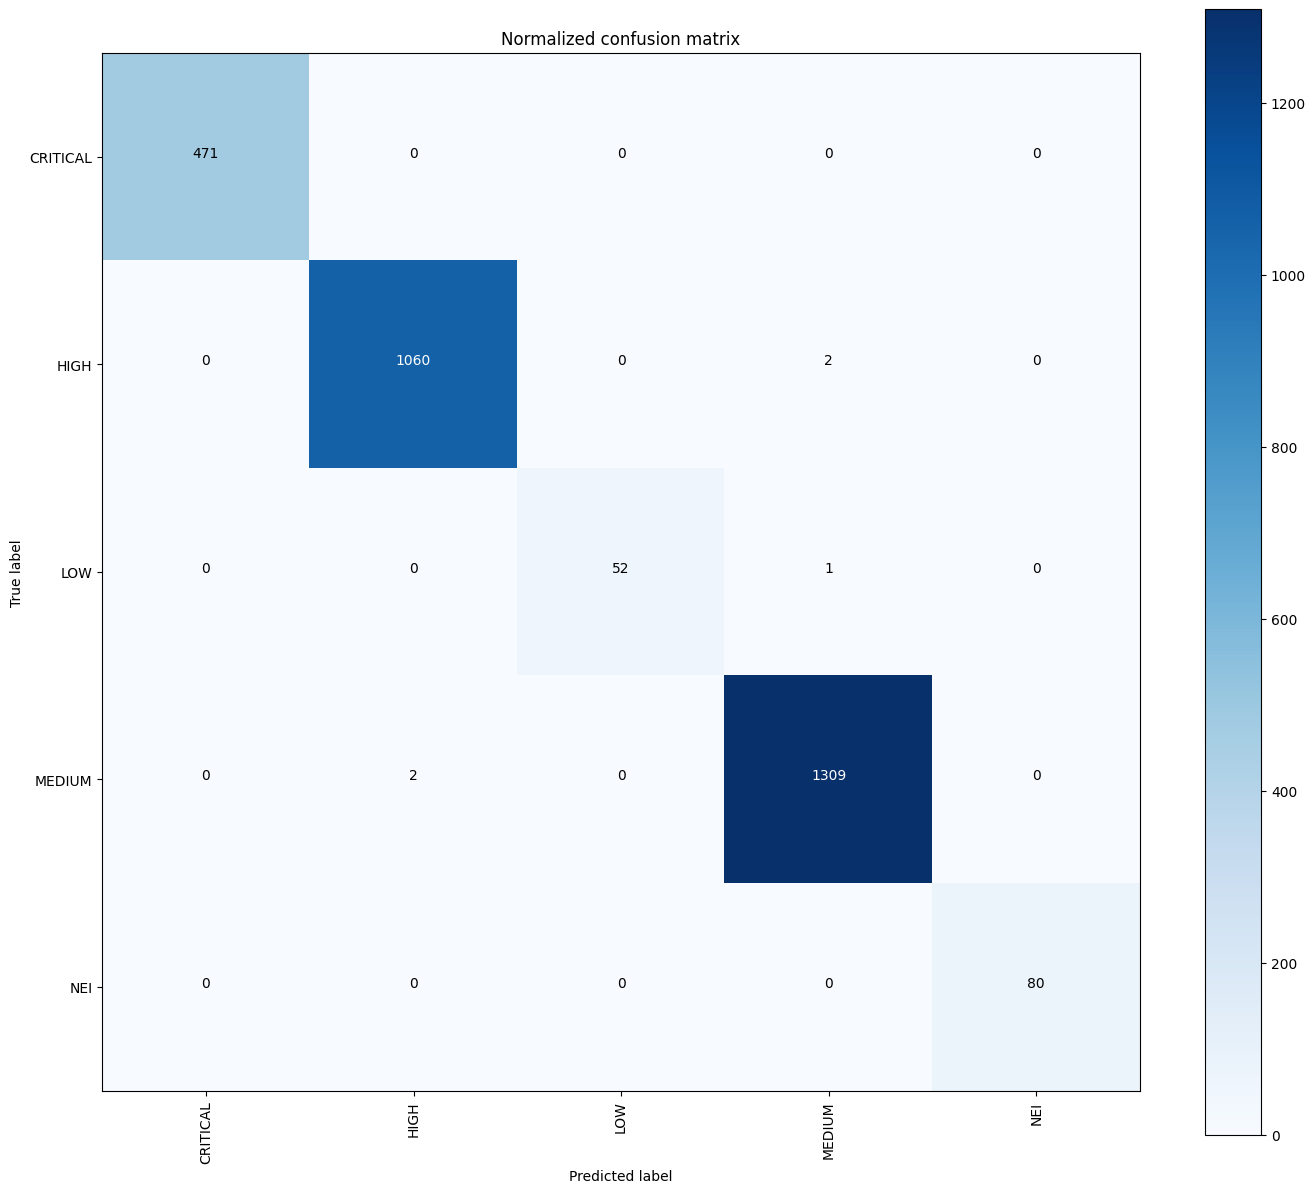

In [79]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
text_labels = encoder.classes_

for i in range(10):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' , y_test[i])
    print("Predicted label: " , predicted_label)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(X_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(encoder.classes_),
                      title='Normalized confusion matrix')
